![for sale image, from https://time.com/5835778/selling-home-coronavirus/](https://api.time.com/wp-content/uploads/2020/05/selling-home-coronavirus.jpg?w=800&quality=85)

# KING COUNTY HOME PRICE PREDICTION

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations. 


## Business Problem

A real estate agency wants us to model the sales price of homes in King County, Washington. They will use our model to help home buyers decide whether homes are underpriced or overpriced. The price of a home can be affected by multiple predictors. We will look at which predictors are statistically significant in terms of affecting a home price. Having a real estate agency use our model will build trust between them and the home buyer. This will likely result in the homebuyer using the same real estate agency if they sell their house in the future.


## Data Understanding

## REVISE LATER THIS WEEK

This data came from Kings County, Washington. It gives us the House Sales for homes in King County, Washington. This will help us model what predicts a sales price for a home buyer. Each data entry represents a house. Our target variable is the price of the home. 

Describe the data being used for this project.

Questions to consider:

- Where did the data come from, and how do they relate to the data analysis questions?
- What do the data represent? Who is in the sample and what variables are included?
- What is the target variable?
- What are the properties of the variables you intend to use?

In [1]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [2]:
 # Basic imports
import numpy as np
import pandas as pd
# Data visualizations
import matplotlib.pyplot as plt
import seaborn as sns
# Pre-Processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import OneHotEncoder
# StatsModel and Metrics
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectKBest, mutual_info_regression

# Install tool to get distance
from geopy import distance

#### Define Utility Function

In [3]:
# # utils.py
# import matplotlib.pyplot as plt
# from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def evaluate(y_train, train_preds, y_test, test_preds, log=False):
    '''
    Evaluate the amount of error between my model's predictionms and the actual values
    for both a train and a test set
    
    Inputs: 
        y_train - array like, actual values for 'price for my train dataset
        train_preds - array like, predicted values for 'price' for my train dataset
        y_test
        test_preds
    
    Outputs:
        None
    '''
    print(f"Train R2: {r2_score(y_train, train_preds):.4f}")
    print(f"Test R2: {r2_score(y_test, test_preds):.4f}")
    print("*****")
    if log == False:
        print(f"Train RMSE: ${mean_squared_error(y_train, train_preds, squared=False):,.2f}")
        print(f"Test RMSE: ${mean_squared_error(y_test, test_preds, squared=False):,.2f}")
        print("*****")
        print(f"Train MAE: ${mean_absolute_error(y_train, train_preds):,.2f}")
        print(f"Test MAE: ${mean_absolute_error(y_test, test_preds):,.2f}")
        print("*****")
    else:
        y_tr_unlog = np.exp(y_train)
        tr_pred_unlog=np.exp(train_preds)
        y_te_unlog=np.exp(y_test)
        te_pred_unlog=np.exp(test_preds)
        print(f"Train RMSE: ${mean_squared_error(y_tr_unlog, tr_pred_unlog, squared=False):,.2f}")
        print(f"Test RMSE: ${mean_squared_error(y_te_unlog, te_pred_unlog, squared=False):,.2f}")
        print("*****")
        print(f"Train MAE: ${mean_absolute_error(y_tr_unlog, tr_pred_unlog):,.2f}")
        print(f"Test MAE: ${mean_absolute_error(y_te_unlog, te_pred_unlog):,.2f}")
        print("*****")
    # Calculate our residuals 
    train_residuals = y_train - train_preds
    test_residuals = y_test - test_preds
    
    # Scatter plot 
    plt.scatter(train_preds, train_residuals, label = 'Train')
    plt.scatter(test_preds, test_residuals, label = 'Test')
    
    plt.axhline(y=0, color = 'red', label = '0')
    plt.xlabel('predictions')
    plt.ylabel('residuals')
    plt.legend()
    
    sm.qqplot(train_residuals, line = 'r', label = 'train residuals');
    plt.legend()
    
    sm.qqplot(test_residuals, line = 'r', label = 'test residuals');
    plt.legend()
    plt.show()     

In [4]:
def next_possible_feature (X_tr, X_te, y_tr, y_te, current_features, ignore_features=[]):
    '''
    This function will loop through each column that isn't in your feature model and 
    calculate the r-squared value if it were the next feature added to your model. It will
    display a dataframe with a sorted r-squared value.
    X_tr = X_train dataframe
    X_te = X_test dataframe
    y_tr = y_train dataframe
    current_features = list of features that are already in your model
    ignore_features = list of features we know are multicollinear that we want to skip over
    '''
    function_dict = {'predictor': [], 'test r-squared':[]}
    for col in X_tr.columns:
        if col not in (current_features+ignore_features) and X_tr[col].dtypes in ['int64', 'float64']:
            function_X_tr = X_tr[current_features + [col]]
            function_X_te = X_te[current_features + [col]]
            function_model  = sm.OLS(y_tr, sm.add_constant(function_X_tr)).fit()
            function_train_preds = function_model.predict(sm.add_constant(function_X_tr))
            function_test_preds = function_model.predict(sm.add_constant(function_X_te))
            function_dict['predictor'].append(col)
            function_dict['test r-squared'].append(r2_score(y_te, function_test_preds))
    function_df = pd.DataFrame(function_dict).sort_values(by=['test r-squared'], ascending = False)
    display(function_df)

#### Read in Data

In [5]:
!ls data

column_names.md
kc_house_data.csv


In [6]:
# Load Housing Data Set
df = pd.read_csv('data/kc_house_data.csv')
df

id        date     price  bedrooms  bathrooms  sqft_living  \
0      7129300520  10/13/2014  221900.0         3       1.00         1180   
1      6414100192   12/9/2014  538000.0         3       2.25         2570   
2      5631500400   2/25/2015  180000.0         2       1.00          770   
3      2487200875   12/9/2014  604000.0         4       3.00         1960   
4      1954400510   2/18/2015  510000.0         3       2.00         1680   
...           ...         ...       ...       ...        ...          ...   
21592   263000018   5/21/2014  360000.0         3       2.50         1530   
21593  6600060120   2/23/2015  400000.0         4       2.50         2310   
21594  1523300141   6/23/2014  402101.0         2       0.75         1020   
21595   291310100   1/16/2015  400000.0         3       2.50         1600   
21596  1523300157  10/15/2014  325000.0         2       0.75         1020   

       sqft_lot  floors waterfront  view  ...          grade sqft_above  \
0          5650     1.0        NaN  NONE  ...      7 Average       1180   
1          7242     2.0         NO  NONE  ...      7 Average       2170   
2         10000     1.0         NO  NONE  ...  6 Low Average        770   
3          5000     1.0         NO  NONE  ...      7 Average       1050   
4          8080     1.0         NO  NONE  ...         8 Good       1680   
...         ...     ...        ...   ...  ...            ...        ...   
21592      1131     3.0         NO  NONE  ...         8 Good       1530   
21593      5813     2.0         NO  NONE  ...         8 Good       2310   
21594      1350     2.0         NO  NONE  ...      7 Average       1020   
21595      2388     2.0        NaN  NONE  ...         8 Good       1600   
21596      1076     2.0         NO  NONE  ...      7 Average       1020   

       sqft_basement yr_built  yr_renovated  zipcode      lat     long  \
0                0.0     1955           0.0    98178  47.5112 -122.257   
1              400.0     1951        1991.0    98125  47.7210 -122.319   
2                0.0     1933           NaN    98028  47.7379 -122.233   
3              910.0     1965           0.0    98136  47.5208 -122.393   
4                0.0     1987           0.0    98074  47.6168 -122.045   
...              ...      ...           ...      ...      ...      ...   
21592            0.0     2009           0.0    98103  47.6993 -122.346   
21593            0.0     2014           0.0    98146  47.5107 -122.362   
21594            0.0     2009           0.0    98144  47.5944 -122.299   
21595            0.0     2004           0.0    98027  47.5345 -122.069   
21596            0.0     2008           0.0    98144  47.5941 -122.299   

       sqft_living15  sqft_lot15  
0               1340        5650  
1               1690        7639  
2               2720        8062  
3               1360        5000  
4               1800        7503  
...              ...         ...  
21592           1530        1509  
21593           1830        7200  
21594           1020        2007  
21595           1410        1287  
21596           1020        1357  

[21597 rows x 21 columns]

In [7]:
#Information on dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [8]:
#Describe the dataframe with descriptive statistics
df.describe()

id         price      bedrooms     bathrooms   sqft_living  \
count  2.159700e+04  2.159700e+04  21597.000000  21597.000000  21597.000000   
mean   4.580474e+09  5.402966e+05      3.373200      2.115826   2080.321850   
std    2.876736e+09  3.673681e+05      0.926299      0.768984    918.106125   
min    1.000102e+06  7.800000e+04      1.000000      0.500000    370.000000   
25%    2.123049e+09  3.220000e+05      3.000000      1.750000   1430.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    sqft_above      yr_built  yr_renovated  \
count  2.159700e+04  21597.000000  21597.000000  21597.000000  17755.000000   
mean   1.509941e+04      1.494096   1788.596842   1970.999676     83.636778   
std    4.141264e+04      0.539683    827.759761     29.375234    399.946414   
min    5.200000e+02      1.000000    370.000000   1900.000000      0.000000   
25%    5.040000e+03      1.000000   1190.000000   1951.000000      0.000000   
50%    7.618000e+03      1.500000   1560.000000   1975.000000      0.000000   
75%    1.068500e+04      2.000000   2210.000000   1997.000000      0.000000   
max    1.651359e+06      3.500000   9410.000000   2015.000000   2015.000000   

            zipcode           lat          long  sqft_living15     sqft_lot15  
count  21597.000000  21597.000000  21597.000000   21597.000000   21597.000000  
mean   98077.951845     47.560093   -122.213982    1986.620318   12758.283512  
std       53.513072      0.138552      0.140724     685.230472   27274.441950  
min    98001.000000     47.155900   -122.519000     399.000000     651.000000  
25%    98033.000000     47.471100   -122.328000    1490.000000    5100.000000  
50%    98065.000000     47.571800   -122.231000    1840.000000    7620.000000  
75%    98118.000000     47.678000   -122.125000    2360.000000   10083.000000  
max    98199.000000     47.777600   -121.315000    6210.000000  871200.000000

In [9]:
df['id'].value_counts()

795000620     3
1825069031    2
2019200220    2
7129304540    2
1781500435    2
             ..
7812801125    1
4364700875    1
3021059276    1
880000205     1
1777500160    1
Name: id, Length: 21420, dtype: int64

In [10]:
df['date'].value_counts()

6/23/2014    142
6/25/2014    131
6/26/2014    131
7/8/2014     127
4/27/2015    126
            ... 
8/30/2014      1
8/3/2014       1
1/31/2015      1
11/2/2014      1
5/27/2015      1
Name: date, Length: 372, dtype: int64

In [11]:
df['price'].value_counts()

350000.0    172
450000.0    172
550000.0    159
500000.0    152
425000.0    150
           ... 
870515.0      1
336950.0      1
386100.0      1
176250.0      1
884744.0      1
Name: price, Length: 3622, dtype: int64

In [12]:
df['bedrooms'].value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [13]:
df['bathrooms'].value_counts()

2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
5.25      13
5.50      10
1.25       9
6.00       6
5.75       4
0.50       4
8.00       2
6.25       2
6.75       2
6.50       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64

In [14]:
#square footage of house living space
df['sqft_living'].value_counts()

1300    138
1400    135
1440    133
1660    129
1010    129
       ... 
4970      1
2905      1
2793      1
4810      1
1975      1
Name: sqft_living, Length: 1034, dtype: int64

In [15]:
#square footage of house lot
df['sqft_lot'].value_counts()

5000      358
6000      290
4000      251
7200      220
7500      119
         ... 
1448        1
38884       1
17313       1
35752       1
315374      1
Name: sqft_lot, Length: 9776, dtype: int64

In [16]:
df['floors'].value_counts()

1.0    10673
2.0     8235
1.5     1910
3.0      611
2.5      161
3.5        7
Name: floors, dtype: int64

In [17]:
#does this house have a waterfront?
df['waterfront'].value_counts()

NO     19075
YES      146
Name: waterfront, dtype: int64

In [18]:
#how well is the view from the house
df['view'].value_counts()

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

In [19]:
df['condition'].value_counts()

Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64

In [20]:
#house grades from poor to mansion
df['grade'].value_counts().sort_index(ascending = False)

9 Better         2615
8 Good           6065
7 Average        8974
6 Low Average    2038
5 Fair            242
4 Low              27
3 Poor              1
13 Mansion         13
12 Luxury          89
11 Excellent      399
10 Very Good     1134
Name: grade, dtype: int64

In [21]:
df['sqft_above'].value_counts()

1300    212
1010    210
1200    206
1220    192
1140    184
       ... 
2601      1
440       1
2473      1
2441      1
1975      1
Name: sqft_above, Length: 942, dtype: int64

In [22]:
df['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
508.0         1
283.0         1
1275.0        1
516.0         1
1880.0        1
Name: sqft_basement, Length: 304, dtype: int64

In [23]:
df['yr_built'].value_counts()

2014    559
2006    453
2005    450
2004    433
2003    420
       ... 
1933     30
1901     29
1902     27
1935     24
1934     21
Name: yr_built, Length: 116, dtype: int64

In [24]:
#year house was renovated, if it was at all
df['yr_renovated'].value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

In [25]:
df['zipcode'].value_counts()

98103    602
98038    589
98115    583
98052    574
98117    553
        ... 
98102    104
98010    100
98024     80
98148     57
98039     50
Name: zipcode, Length: 70, dtype: int64

In [26]:
#latitude of house
df['lat'].value_counts()

47.6846    17
47.5322    17
47.6624    17
47.5491    17
47.6886    16
           ..
47.3104     1
47.4681     1
47.2819     1
47.6096     1
47.4300     1
Name: lat, Length: 5033, dtype: int64

In [27]:
#longitude of house
df['long'].value_counts()

-122.290    115
-122.300    111
-122.362    104
-122.291    100
-122.372     99
           ... 
-121.803      1
-121.711      1
-122.454      1
-121.835      1
-121.849      1
Name: long, Length: 751, dtype: int64

In [28]:
#square footage of living space for the 15 closest neighbors
df['sqft_living15'].value_counts()

1540    197
1440    195
1560    192
1500    180
1460    169
       ... 
4890      1
2873      1
952       1
3193      1
2049      1
Name: sqft_living15, Length: 777, dtype: int64

In [29]:
#square footage of lot space for the 15 closest neighbors
df['sqft_lot15'].value_counts()

5000      427
4000      356
6000      288
7200      210
4800      145
         ... 
11036       1
8989        1
871200      1
809         1
6147        1
Name: sqft_lot15, Length: 8682, dtype: int64

## Data Preparation

Describe and justify the process for preparing the data for analysis.

Questions to consider:

- Were there variables you dropped or created?
- How did you address missing values or outliers?
- Why are these choices appropriate given the data and the business problem?

In [30]:
df[df['bedrooms']==33]

id       date     price  bedrooms  bathrooms  sqft_living  \
15856  2402100895  6/25/2014  640000.0        33       1.75         1620   

       sqft_lot  floors waterfront  view  ...      grade sqft_above  \
15856      6000     1.0         NO  NONE  ...  7 Average       1040   

       sqft_basement yr_built  yr_renovated  zipcode      lat     long  \
15856          580.0     1947           0.0    98103  47.6878 -122.331   

       sqft_living15  sqft_lot15  
15856           1330        4700  

[1 rows x 21 columns]

In [31]:
#Replace 33 bedrooms with 3 bedrooms, since 3 is the mean for bedroom count in this dataset
#We suspect this was a typing error when entering the home data
df['bedrooms'].replace(33, 3, inplace=True)

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


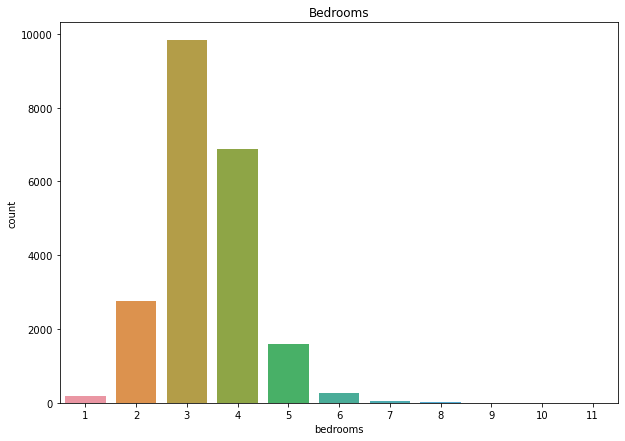

In [32]:
plt.figure(figsize=(10,7))

plt.title('Bedrooms')
sns.countplot(df['bedrooms'])

plt.show();

### Since bedrooms is skewed, we are going to filter our data to only houses with less than 7 bedrooms

In [33]:
df = df[df['bedrooms']<7]

In [34]:
df[df['sqft_basement']=='?']

id        date      price  bedrooms  bathrooms  sqft_living  \
6      1321400060   6/27/2014   257500.0         3       2.25         1715   
18       16000397   12/5/2014   189000.0         2       1.00         1200   
42     7203220400    7/7/2014   861990.0         5       2.75         3595   
79     1531000030   3/23/2015   720000.0         4       2.50         3450   
112    2525310310   9/16/2014   272500.0         3       1.75         1540   
...           ...         ...        ...       ...        ...          ...   
21442  3226049565   7/11/2014   504600.0         5       3.00         2360   
21447  1760650900   7/21/2014   337500.0         4       2.50         2330   
21473  6021503707   1/20/2015   352500.0         2       2.50          980   
21519  2909310100  10/15/2014   332000.0         4       2.50         2380   
21581   191100405   4/21/2015  1580000.0         4       3.25         3410   

       sqft_lot  floors waterfront  view  ...         grade sqft_above  \
6          6819     2.0         NO  NONE  ...     7 Average       1715   
18         9850     1.0         NO  NONE  ...     7 Average       1200   
42         5639     2.0         NO  NONE  ...      9 Better       3595   
79        39683     2.0         NO  NONE  ...  10 Very Good       3450   
112       12600     1.0         NO  NONE  ...     7 Average       1160   
...         ...     ...        ...   ...  ...           ...        ...   
21442      5000     1.0         NO  NONE  ...     7 Average       1390   
21447      4907     2.0         NO  NONE  ...     7 Average       2330   
21473      1010     3.0        NaN  NONE  ...        8 Good        980   
21519      5737     2.0         NO  NONE  ...     7 Average       2380   
21581     10125     2.0         NO  NONE  ...  10 Very Good       3410   

       sqft_basement yr_built  yr_renovated  zipcode      lat     long  \
6                  ?     1995           0.0    98003  47.3097 -122.327   
18                 ?     1921           0.0    98002  47.3089 -122.210   
42                 ?     2014           0.0    98053  47.6848 -122.016   
79                 ?     2002           0.0    98010  47.3420 -122.025   
112                ?     1980           0.0    98038  47.3624 -122.031   
...              ...      ...           ...      ...      ...      ...   
21442              ?     2008           0.0    98103  47.6931 -122.330   
21447              ?     2013           NaN    98042  47.3590 -122.081   
21473              ?     2008           0.0    98117  47.6844 -122.387   
21519              ?     2010           0.0    98023  47.2815 -122.356   
21581              ?     2007           NaN    98040  47.5653 -122.223   

       sqft_living15  sqft_lot15  
6               2238        6819  
18              1060        5095  
42              3625        5639  
79              3350       39750  
112             1540       11656  
...              ...         ...  
21442           2180        5009  
21447           2300        3836  
21473            980        1023  
21519           2380        5396  
21581           2290       10125  

[452 rows x 21 columns]

In [35]:
#Change ? entries for sqft_basement
#This is done by subtracting the sqft_above from sqft_living
df['sqft_basement_diff']= df['sqft_living'] - df['sqft_above']
df.drop('sqft_basement', axis = 1, inplace = True)

<ipython-input-35-0219bbd448ad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sqft_basement_diff']= df['sqft_living'] - df['sqft_above']
C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


#### Check null values in the dataframe

In [36]:
df.isna().sum()

id                       0
date                     0
price                    0
bedrooms                 0
bathrooms                0
sqft_living              0
sqft_lot                 0
floors                   0
waterfront            2371
view                    63
condition                0
grade                    0
sqft_above               0
yr_built                 0
yr_renovated          3828
zipcode                  0
lat                      0
long                     0
sqft_living15            0
sqft_lot15               0
sqft_basement_diff       0
dtype: int64

In [37]:
#Change the entries in waterfront from YES/NO to 1/0
df['waterfront'].replace("YES", 1, inplace=True)
df['waterfront'].replace("NO", 0, inplace=True)
df['waterfront'].fillna(value=0,inplace=True)

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [38]:
#Change the null entries for yr_renovated to 0
df['yr_renovated'].fillna(value=0,inplace=True)

In [39]:
#Change the null values for view to NONE
df['view'].fillna(value='NONE',inplace=True)

In [40]:
#Create a column that with any house that has a view, no matter how well it is
#This essentially is the inverse of the 'view_NONE' column
df['view_YES'] = df['view']
df['view_YES'].replace('NONE', 0, inplace=True)
df['view_YES'].replace(['AVERAGE','GOOD','FAIR', 'EXCELLENT'], 1, inplace = True)
#MAYBE BEFORE WE SUBMIT, CREATE TWO COLUMNS, VIEW ABOVE AVERAGE, VIEW BELOW AVERAGE
# df['view_YES'].replace('GOOD', 1, inplace = True)
# df['view_YES'].replace('FAIR', 1, inplace = True)
# df['view_YES'].replace('EXCELLENT', 1, inplace = True)
df['view_YES'].value_counts()

<ipython-input-40-e9fcf2a903f1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['view_YES'] = df['view']


0    19435
1     2101
Name: view_YES, dtype: int64

In [41]:
#Add a column that calculates the distance from the downtown
distance_data = []
for i in df.index:
    location = (df.loc[i]['lat'],df.loc[i]['long'])
    downtown = (47.6050, -122.3344)
    dist = distance.distance(location, downtown).miles
    distance_data.append(dist)
df['distance'] = distance_data

<ipython-input-41-b60eb993040e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance'] = distance_data


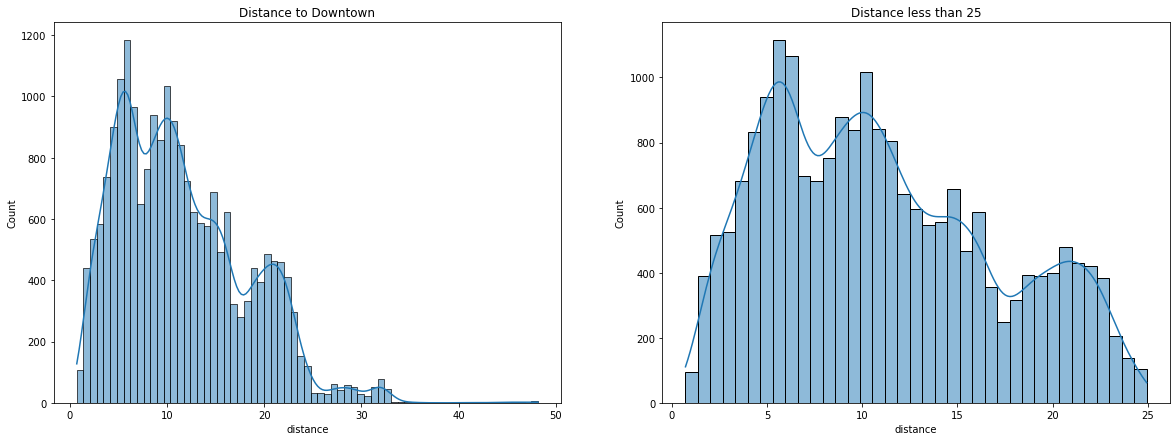

In [42]:
plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
plt.title('Distance to Downtown')
sns.histplot(df['distance'], kde=True)

plt.subplot(1,2,2)
plt.title('Distance less than 25')
sns.histplot(df[df['distance']<25]['distance'], kde=True)

plt.show()

In [43]:
ratio_within_25_miles = len(df[df['distance']<25])/len(df['distance'])
ratio_within_25_miles
#97.5 percent of the houses are still being used.

0.974739970282318

In [44]:
# Import
import plotly.express as px

# Explore relationship between location and price
fig = px.scatter_mapbox(data_frame = df, # df name
                        lat='lat', # name of latitude column
                        lon='long', # name of longitude column
                        color='distance', # name of column to use for the color
                        zoom=8)

fig.update_layout(mapbox_style="open-street-map")

### Since our data includes outliers for distance from downtown, we filtered the data by only looking at houses within 25 miles

In [45]:
#Filter dataset by only including houses within 25 miles
df = df[df['distance']<25]

In [46]:
#for new 'house_age' column:
age_data = []
for i in df.index:
    if df.loc[i]['yr_renovated']==0.0:
        age = 2016 - df.loc[i]['yr_built']  
    else:
        age = 2016 - df.loc[i]['yr_renovated']
    age_data.append(age)

df['house_age'] = age_data
#df['house_age'] = [2016]*len(df['yr_built']) - df['yr_built']

In [47]:
df[['house_age']].value_counts()

house_age
2.0          620
11.0         472
10.0         467
13.0         447
12.0         447
            ... 
114.0         26
115.0         26
83.0          23
81.0          19
82.0          13
Length: 116, dtype: int64

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20992 entries, 0 to 21596
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  20992 non-null  int64  
 1   date                20992 non-null  object 
 2   price               20992 non-null  float64
 3   bedrooms            20992 non-null  int64  
 4   bathrooms           20992 non-null  float64
 5   sqft_living         20992 non-null  int64  
 6   sqft_lot            20992 non-null  int64  
 7   floors              20992 non-null  float64
 8   waterfront          20992 non-null  float64
 9   view                20992 non-null  object 
 10  condition           20992 non-null  object 
 11  grade               20992 non-null  object 
 12  sqft_above          20992 non-null  int64  
 13  yr_built            20992 non-null  int64  
 14  yr_renovated        20992 non-null  float64
 15  zipcode             20992 non-null  int64  
 16  lat 

In [49]:
df.isna().sum()

id                    0
date                  0
price                 0
bedrooms              0
bathrooms             0
sqft_living           0
sqft_lot              0
floors                0
waterfront            0
view                  0
condition             0
grade                 0
sqft_above            0
yr_built              0
yr_renovated          0
zipcode               0
lat                   0
long                  0
sqft_living15         0
sqft_lot15            0
sqft_basement_diff    0
view_YES              0
distance              0
house_age             0
dtype: int64

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20992 entries, 0 to 21596
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  20992 non-null  int64  
 1   date                20992 non-null  object 
 2   price               20992 non-null  float64
 3   bedrooms            20992 non-null  int64  
 4   bathrooms           20992 non-null  float64
 5   sqft_living         20992 non-null  int64  
 6   sqft_lot            20992 non-null  int64  
 7   floors              20992 non-null  float64
 8   waterfront          20992 non-null  float64
 9   view                20992 non-null  object 
 10  condition           20992 non-null  object 
 11  grade               20992 non-null  object 
 12  sqft_above          20992 non-null  int64  
 13  yr_built            20992 non-null  int64  
 14  yr_renovated        20992 non-null  float64
 15  zipcode             20992 non-null  int64  
 16  lat 

In [51]:
df.select_dtypes(include = "object")

date  view  condition          grade
0      10/13/2014  NONE    Average      7 Average
1       12/9/2014  NONE    Average      7 Average
2       2/25/2015  NONE    Average  6 Low Average
3       12/9/2014  NONE  Very Good      7 Average
4       2/18/2015  NONE    Average         8 Good
...           ...   ...        ...            ...
21592   5/21/2014  NONE    Average         8 Good
21593   2/23/2015  NONE    Average         8 Good
21594   6/23/2014  NONE    Average      7 Average
21595   1/16/2015  NONE    Average         8 Good
21596  10/15/2014  NONE    Average      7 Average

[20992 rows x 4 columns]

In [52]:
obj_column = [c for c in df.columns if df[c].dtype == 'object']
df[obj_column].describe()

date   view condition      grade
count       20992  20992     20992      20992
unique        372      5         5         10
top     6/23/2014   NONE   Average  7 Average
freq          139  18990     13639       8696

In [53]:
df['grade_int'] = df['grade'].str[:2].astype(int)
df['grade_int']

0        7
1        7
2        6
3        7
4        8
        ..
21592    8
21593    8
21594    7
21595    8
21596    7
Name: grade_int, Length: 20992, dtype: int32

In [54]:
df['grade_int'].value_counts()

7     8696
8     5925
9     2552
6     1965
10    1115
11     393
5      222
12      84
4       27
13      13
Name: grade_int, dtype: int64

In [55]:
df['grade_below_average'] = df['grade_int']
df['grade_below_average'].replace([4,5,6,7], 1, inplace=True)
df['grade_below_average'].replace([8,9,10,11, 12, 13], 0, inplace=True)
df['grade_below_average'].value_counts()

1    10910
0    10082
Name: grade_below_average, dtype: int64

In [56]:
df['grade_above_average'] = df['grade_int']
df['grade_above_average'].replace([10,11,12,13], 1, inplace=True)
df['grade_above_average'].replace([8,9,4,5, 6, 7], 0, inplace=True)
df['grade_above_average'].value_counts()

0    19387
1     1605
Name: grade_above_average, dtype: int64

In [57]:
df['grade_is_average'] = df['grade_int']
df['grade_is_average'].replace([8,9], 1, inplace=True)
df['grade_is_average'].replace([4,5,6,7,10,11,12,13], 0, inplace=True)
df['grade_is_average'].value_counts()

0    12515
1     8477
Name: grade_is_average, dtype: int64

In [58]:
df.drop("grade", axis=1, inplace=True)
df.drop('grade_int', axis=1, inplace=True)

In [59]:
# Create a variable for view column
view_col = df[["view"]]
condition_df = df[["condition"]]
#grade_df = df[['grade']]

# Instantiate a OneHotEncoder with categories="auto",
# sparse=False, and handle_unknown="ignore"
ohe_view = OneHotEncoder(categories="auto",sparse=False, handle_unknown="ignore")
ohe_cond = OneHotEncoder(categories="auto", sparse=False, handle_unknown="ignore")
#ohe_grade = OneHotEncoder(categories = 'auto', sparse=False, handle_unknown ='ignore')

# Fit the encoder on view_col
ohe_view.fit(view_col)
ohe_cond.fit(condition_df)
#ohe_grade.fit(grade_df)

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [60]:
# Transform view_col using the encoder and
# assign the result to view_col_encoded
view_col_encoded = ohe_view.transform(view_col)
condition_df_encoded = ohe_cond.transform(condition_df)
#grade_encoded = ohe_grade.transform(grade_df)

In [61]:
# Make the transformed data into a dataframe
view_col_encoded = pd.DataFrame(
    # Pass in NumPy array
    view_col_encoded,
    # Set the column names to the categories found by OHE
    columns="view_"+ohe_view.categories_[0],
    # Set the index to match df's index
    index=df.index
)
condition_df_encoded = pd.DataFrame(
    # Pass in NumPy array
    condition_df_encoded,
    # Set the column names to the categories found by OHE
    columns="cond_"+ohe_cond.categories_[0],
    # Set the index to match df's index
    index=df.index
)
#grade_encoded = pd.DataFrame(grade_encoded,columns="grade_"+ohe_grade.categories_[0],index=df.index)

In [62]:
# Drop original view column
df.drop("view", axis=1, inplace=True)
df.drop("condition", axis=1, inplace=True)
#df.drop("grade", axis=1, inplace=True)

# Concatenate the new dataframe with current df
df = pd.concat([df, view_col_encoded, condition_df_encoded], axis=1)
#df = pd.concat([df, view_col_encoded, condition_df_encoded, grade_encoded], axis=1)

# Visually inspect df
df.head()

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   
2  5631500400   2/25/2015  180000.0         2       1.00          770   
3  2487200875   12/9/2014  604000.0         4       3.00         1960   
4  1954400510   2/18/2015  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  sqft_above  ...  view_AVERAGE  \
0      5650     1.0         0.0        1180  ...           0.0   
1      7242     2.0         0.0        2170  ...           0.0   
2     10000     1.0         0.0         770  ...           0.0   
3      5000     1.0         0.0        1050  ...           0.0   
4      8080     1.0         0.0        1680  ...           0.0   

   view_EXCELLENT  view_FAIR  view_GOOD  view_NONE  cond_Average  cond_Fair  \
0             0.0        0.0        0.0        1.0           1.0        0.0   
1             0.0        0.0        0.0        1.0           1.0        0.0   
2             0.0        0.0        0.0        1.0           1.0        0.0   
3             0.0        0.0        0.0        1.0           0.0        0.0   
4             0.0        0.0        0.0        1.0           1.0        0.0   

   cond_Good  cond_Poor  cond_Very Good  
0        0.0        0.0             0.0  
1        0.0        0.0             0.0  
2        0.0        0.0             0.0  
3        0.0        0.0             1.0  
4        0.0        0.0             0.0  

[5 rows x 34 columns]

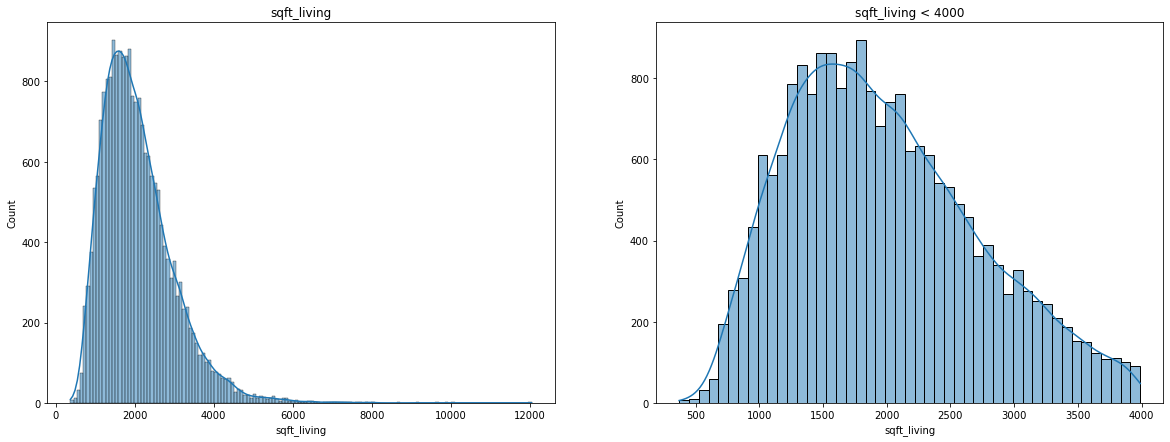

In [63]:
plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
plt.title('sqft_living')
sns.histplot(df['sqft_living'], kde=True)

plt.subplot(1,2,2)
plt.title('sqft_living < 4000')
sns.histplot(df[df['sqft_living']<4000]['sqft_living'], kde=True)

plt.show()

In [64]:
#We transformed the sqft_living column because it is heavily skewed
# df['logged_sqft_living'] = np.log(df['sqft_living'])
df = df[df['sqft_living']<4000]

#### We filtered sqft to only less than 4000 so that it isn't as heavily skewed

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20240 entries, 0 to 21596
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   20240 non-null  int64  
 1   date                 20240 non-null  object 
 2   price                20240 non-null  float64
 3   bedrooms             20240 non-null  int64  
 4   bathrooms            20240 non-null  float64
 5   sqft_living          20240 non-null  int64  
 6   sqft_lot             20240 non-null  int64  
 7   floors               20240 non-null  float64
 8   waterfront           20240 non-null  float64
 9   sqft_above           20240 non-null  int64  
 10  yr_built             20240 non-null  int64  
 11  yr_renovated         20240 non-null  float64
 12  zipcode              20240 non-null  int64  
 13  lat                  20240 non-null  float64
 14  long                 20240 non-null  float64
 15  sqft_living15        20240 non-null 

## Modeling

Describe and justify the process for analyzing or modeling the data.

Questions to consider:

- How did you analyze the data to arrive at an initial approach?
- How did you iterate on your initial approach to make it better?
- Why are these choices appropriate given the data and the business problem?

In [66]:
X = df.drop(columns=['id', 'price'])
y = df['price']

In [67]:
# Train - Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [68]:
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

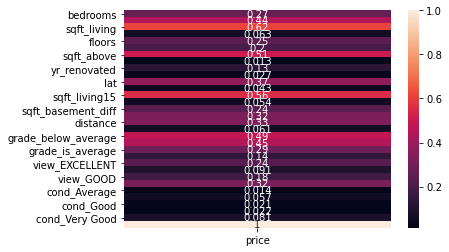

In [69]:
# Absolute value correlations with price
sns.heatmap(abs(train_df.corr())[['price']], annot=True);

In [70]:
np.abs(train_df.corr()['price']).sort_values(ascending = False)

price                  1.000000
sqft_living            0.615192
sqft_living15          0.558321
sqft_above             0.508928
grade_below_average    0.485091
grade_above_average    0.445501
bathrooms              0.442628
lat                    0.370227
distance               0.331252
view_NONE              0.322129
view_YES               0.322129
grade_is_average       0.290636
bedrooms               0.274064
floors                 0.249004
view_EXCELLENT         0.244042
sqft_basement_diff     0.242756
waterfront             0.198257
view_GOOD              0.179535
view_AVERAGE           0.143465
yr_renovated           0.127840
view_FAIR              0.090957
cond_Very Good         0.081278
sqft_lot               0.062698
house_age              0.061249
cond_Fair              0.056894
sqft_lot15             0.053681
long                   0.042632
zipcode                0.026605
cond_Poor              0.021993
cond_Good              0.021476
cond_Average           0.013992
yr_built

## Evaluation

The evaluation of each model should accompany the creation of each model, and you should be sure to evaluate your models consistently.

Evaluate how well your work solves the stated business problem. 

Questions to consider:

- How do you interpret the results?
- How well does your model fit your data? How much better is this than your baseline model? Is it over or under fit?
- How well does your model/data fit any modeling assumptions?

For the final model, you might also consider:

- How confident are you that your results would generalize beyond the data you have?
- How confident are you that this model would benefit the business if put into use?

### Baseline Understanding

- What does a baseline, model-less prediction look like?

In [71]:
# code here to arrive at a baseline prediction
train_target_mean = y_train.mean()
train_target_mean

506374.89743083005

Train R2: 0.0000
Test R2: -0.0000
*****
Train RMSE: $273,506.98
Test RMSE: $274,507.34
*****
Train MAE: $196,818.79
Test MAE: $198,129.72
*****


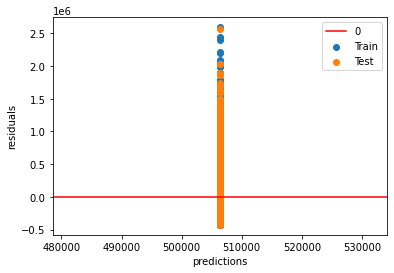

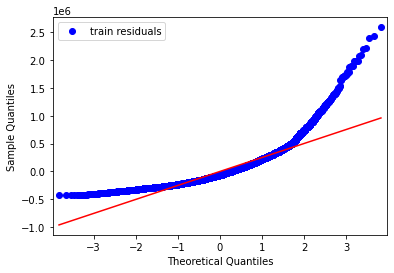

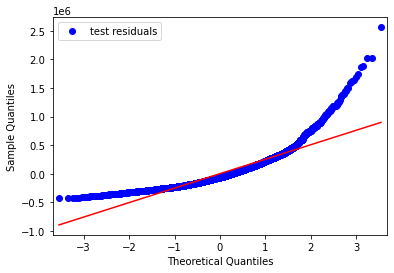

In [72]:
baseline_train_preds = [train_target_mean]*len(y_train)
baseline_test_preds = [train_target_mean]*len(y_test)
evaluate(y_train, baseline_train_preds, y_test, baseline_test_preds)

### First Simple Model

Before going too far down the data preparation rabbit hole, be sure to check your work against a first 'substandard' model! What is the easiest way for you to find out how hard your problem is?

In [73]:
np.abs(train_df.corr()['price']).sort_values(ascending = False)
#train_df.corr()['price'].sort_values(ascending = False)

price                  1.000000
sqft_living            0.615192
sqft_living15          0.558321
sqft_above             0.508928
grade_below_average    0.485091
grade_above_average    0.445501
bathrooms              0.442628
lat                    0.370227
distance               0.331252
view_NONE              0.322129
view_YES               0.322129
grade_is_average       0.290636
bedrooms               0.274064
floors                 0.249004
view_EXCELLENT         0.244042
sqft_basement_diff     0.242756
waterfront             0.198257
view_GOOD              0.179535
view_AVERAGE           0.143465
yr_renovated           0.127840
view_FAIR              0.090957
cond_Very Good         0.081278
sqft_lot               0.062698
house_age              0.061249
cond_Fair              0.056894
sqft_lot15             0.053681
long                   0.042632
zipcode                0.026605
cond_Poor              0.021993
cond_Good              0.021476
cond_Average           0.013992
yr_built

In [74]:
# code here for your first 'substandard' model
fsm_X_train= X_train['sqft_living']
fsm_X_test = X_test['sqft_living']
fsm = sm.OLS(y_train, sm.add_constant(fsm_X_train)).fit()
fsm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     9242.
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        10:59:36   Log-Likelihood:            -2.0797e+05
No. Observations:               15180   AIC:                         4.159e+05
Df Residuals:                   15178   BIC:                         4.160e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.853e+04   4976.369     11.762      0.000    4.88e+04    6.83e+04
sqft_living   226.2158      2.353     96.136      0.000     221.603     230.828
==============================================================================
Omnibus:                     6631.401   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            58410.229
Skew:                           1.879   Prob(JB):                         0.00
Kurtosis:                      11.844   Cond. No.                     6.01e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Train R2: 0.3785
Test R2: 0.3690
*****
Train RMSE: $215,626.67
Test RMSE: $218,060.00
*****
Train MAE: $152,975.65
Test MAE: $155,378.69
*****


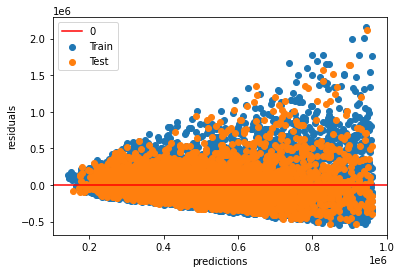

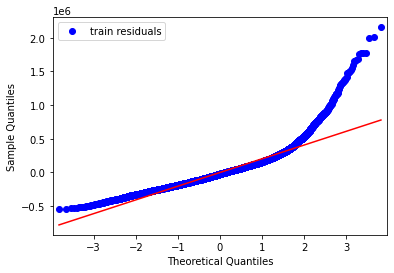

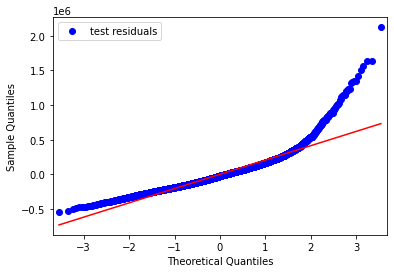

In [75]:
# code here to evaluate your first 'substandard' model
fsm_train_preds = fsm.predict(sm.add_constant(fsm_X_train))
fsm_test_preds = fsm.predict(sm.add_constant(fsm_X_test))

evaluate(y_train, fsm_train_preds, y_test, fsm_test_preds)

#### As seen from the residuals plot above, there is heteroskedasticity problem, which means that the spread of residuals is different at different levels of the fitted values. In order to overcome heteroskedasticity, we can do variable transformation (i.e. log transformation) of the target column.

In [76]:
logged_fsm_y_train= np.log(y_train)
logged_fsm_y_test = np.log(y_test)
fsm_logged = sm.OLS(logged_fsm_y_train, sm.add_constant(fsm_X_train)).fit()
fsm_logged.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                 1.019e+04
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        10:59:40   Log-Likelihood:                -6616.4
No. Observations:               15180   AIC:                         1.324e+04
Df Residuals:                   15178   BIC:                         1.325e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.1989      0.009   1412.720      0.000      12.182      12.216
sqft_living     0.0004   4.08e-06    100.940      0.000       0.000       0.000
==============================================================================
Omnibus:                       41.584   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.781
Skew:                           0.037   Prob(JB):                     4.62e-08
Kurtosis:                       2.781   Cond. No.                     6.01e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Train R2: 0.4017
Test R2: 0.3954
*****
Train RMSE: $215,985.68
Test RMSE: $219,501.20
*****
Train MAE: $149,541.04
Test MAE: $152,564.16
*****


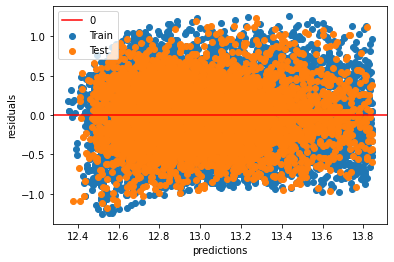

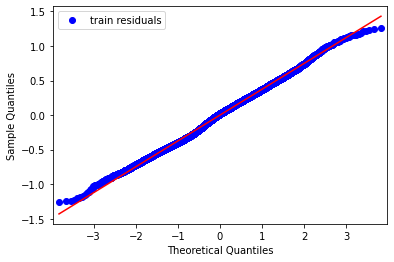

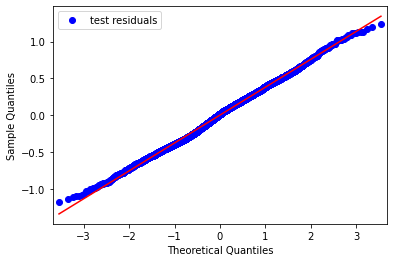

In [77]:
logged_fsm_train_preds = fsm_logged.predict(sm.add_constant(fsm_X_train))
logged_fsm_test_preds = fsm_logged.predict(sm.add_constant(fsm_X_test))

evaluate(logged_fsm_y_train, logged_fsm_train_preds, logged_fsm_y_test, logged_fsm_test_preds, log=True)

### Modeling Iterations

Now you can start to use the results of your first model to iterate - there are many options!

In [78]:
# code here to iteratively improve your models
selected_features = ['sqft_living']
next_possible_feature (X_tr=X_train, X_te=X_test, y_tr=logged_fsm_y_train,\
                       y_te=logged_fsm_y_test,current_features=selected_features)


predictor  test r-squared
15            distance        0.604982
9                  lat        0.601131
14            view_YES        0.428099
21           view_NONE        0.428099
6             yr_built        0.425187
16           house_age        0.416256
11       sqft_living15        0.415519
18      view_EXCELLENT        0.413810
10                long        0.411639
8              zipcode        0.407428
4           waterfront        0.405706
17        view_AVERAGE        0.403720
26      cond_Very Good        0.402864
0             bedrooms        0.401932
7         yr_renovated        0.401414
20           view_GOOD        0.400840
22        cond_Average        0.399796
3               floors        0.399302
23           cond_Fair        0.398964
19           view_FAIR        0.398559
24           cond_Good        0.396303
5           sqft_above        0.396228
13  sqft_basement_diff        0.396228
12          sqft_lot15        0.396190
1            bathrooms        0.395767
2             sqft_lot        0.395678
25           cond_Poor        0.395410

#### We noticed that 'distance' and 'lat' had the highest r-squared score when combined with 'sqft_living'. Since 'distance' is dependent on 'lat', we chose 'distance' as our next predictor.

Train R2: 0.6077
Test R2: 0.6050
*****
Train RMSE: $175,188.01
Test RMSE: $179,659.77
*****
Train MAE: $118,422.20
Test MAE: $120,104.09
*****


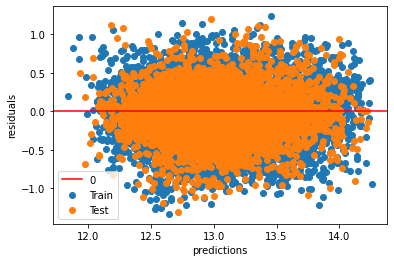

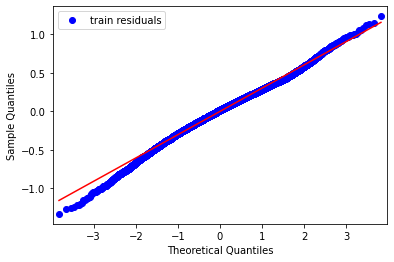

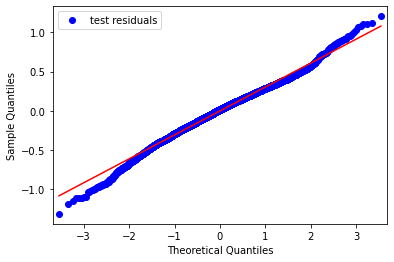

In [79]:
second_predictors = ['sqft_living', 'distance']
second_X_train= X_train[second_predictors]
second_X_test = X_test[second_predictors]
second_model = sm.OLS(logged_fsm_y_train, sm.add_constant(second_X_train)).fit()
second_train_preds = second_model.predict(sm.add_constant(second_X_train))
second_test_preds = second_model.predict(sm.add_constant(second_X_test))
evaluate(logged_fsm_y_train, second_train_preds , logged_fsm_y_test, second_test_preds, log=True)

In [80]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# defining an empty dataframe to capture the VIF scores
vif_2 = pd.DataFrame()

# label the scores with their related columns
vif_2["features"] = second_X_train.columns

# For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score

vif_2["VIF"] = [variance_inflation_factor(second_X_train.values, i) \
                for i in range(len(second_X_train.columns))]

vif_2

features       VIF
0  sqft_living  3.551145
1     distance  3.551145

### We used VIF to check for Multicollinearity. Since the values are less than 7, they aren't multicollinear.

In [81]:
second_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                 1.175e+04
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        10:59:51   Log-Likelihood:                -3412.8
No. Observations:               15180   AIC:                             6832.
Df Residuals:                   15177   BIC:                             6855.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.5275      0.008   1585.412      0.000      12.512      12.543
sqft_living     0.0005   3.34e-06    135.976      0.000       0.000       0.000
distance       -0.0372      0.000    -89.274      0.000      -0.038      -0.036
==============================================================================
Omnibus:                      291.718   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              384.398
Skew:                          -0.251   Prob(JB):                     3.38e-84
Kurtosis:                       3.597   Cond. No.                     6.80e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.8e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Third iteration with 'sqft_living' and 'distance' as our default predictors

In [82]:
# code here to iteratively improve your models
#latitude and longitude is also selected because we know that distance is dependent on them
selected_features = ['sqft_living','distance']
features_to_ignore = ['lat','long']
next_possible_feature (X_tr=X_train, X_te=X_test, y_tr=logged_fsm_y_train, \
                       y_te=logged_fsm_y_test, current_features=selected_features, \
                       ignore_features=features_to_ignore)


predictor  test r-squared
9        sqft_living15        0.651648
8              zipcode        0.628863
5           sqft_above        0.617643
11  sqft_basement_diff        0.617643
12            view_YES        0.616821
18           view_NONE        0.616821
15      view_EXCELLENT        0.616602
4           waterfront        0.615659
10          sqft_lot15        0.611394
0             bedrooms        0.610837
2             sqft_lot        0.610359
3               floors        0.608623
20           cond_Fair        0.608154
1            bathrooms        0.608051
14        view_AVERAGE        0.607162
17           view_GOOD        0.606834
13           house_age        0.606312
7         yr_renovated        0.606044
21           cond_Good        0.605947
19        cond_Average        0.605891
23      cond_Very Good        0.605651
16           view_FAIR        0.605487
6             yr_built        0.605469
22           cond_Poor        0.605215

#### We noticed that 'grade_int' had the highest r-squared score when combined with 'sqft_living' and 'distance'.

In [83]:
# defining an empty dataframe to capture the VIF scores
vif_3 = pd.DataFrame()

third_X_train = X_train[['sqft_living', 'distance', 'sqft_living15']]

# label the scores with their related columns
vif_3["features"] = third_X_train.columns

# For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score

vif_3["VIF"] = [variance_inflation_factor(third_X_train.values, i) \
                for i in range(len(third_X_train.columns))]

vif_3

features        VIF
0    sqft_living  17.199451
1       distance   4.051939
2  sqft_living15  19.580924

In [84]:
third_X_train = X_train[['sqft_living', 'distance', 'grade_below_average']]
# defining an empty dataframe to capture the VIF scores
vif_3 = pd.DataFrame()

# label the scores with their related columns
vif_3["features"] = third_X_train.columns

# For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score

vif_3["VIF"] = [variance_inflation_factor(third_X_train.values, i) \
                for i in range(len(third_X_train.columns))]

vif_3

features       VIF
0          sqft_living  3.554153
1             distance  4.140405
2  grade_below_average  1.663636

Train R2: 0.6378
Test R2: 0.6420
*****
Train RMSE: $168,564.53
Test RMSE: $172,017.32
*****
Train MAE: $113,270.01
Test MAE: $113,996.50
*****


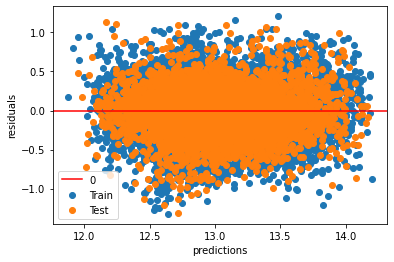

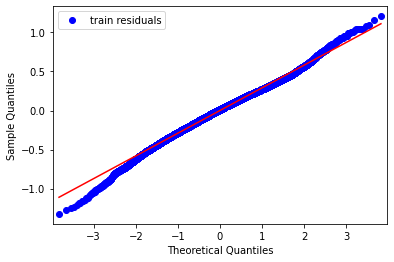

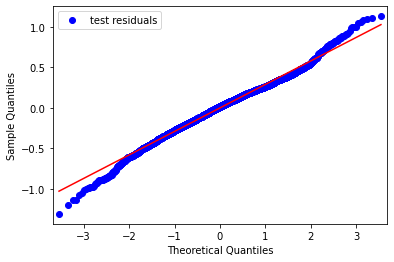

In [85]:
third_predictors = ['sqft_living', 'distance', 'grade_below_average']
third_X_train= X_train[third_predictors]
third_X_test = X_test[third_predictors]
third_model = sm.OLS(logged_fsm_y_train, sm.add_constant(third_X_train)).fit()
third_train_preds = third_model.predict(sm.add_constant(third_X_train))
third_test_preds = third_model.predict(sm.add_constant(third_X_test))
evaluate(logged_fsm_y_train, third_train_preds , logged_fsm_y_test, third_test_preds, log=True)

In [86]:
third_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     8906.
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        10:59:55   Log-Likelihood:                -2807.4
No. Observations:               15180   AIC:                             5623.
Df Residuals:                   15176   BIC:                             5653.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  12.7934      0.011   1199.368      0.000      12.772      12.814
sqft_living             0.0004   3.95e-06     94.262      0.000       0.000       0.000
distance               -0.0365      0.000    -91.139      0.000      -0.037      -0.036
grade_below_average    -0.2073      0.006    -35.498      0.000      -0.219      -0.196
==============================================================================
Omnibus:                      249.686   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              367.741
Skew:                          -0.188   Prob(JB):                     1.40e-80
Kurtosis:                       3.663   Cond. No.                     1.03e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Fourth Iteration of Model

In [87]:
# code here to iteratively improve your models
#latitude and longitude is selected because we know that distance is dependent on them
#sqft_living15 and grade_int is selcted because we know they wont work from the previous model
selected_features = ['sqft_living','distance', 'grade_below_average']
features_to_ignore = ['lat', 'long', 'sqft_living15']
next_possible_feature (X_tr=X_train, X_te=X_test, y_tr=logged_fsm_y_train, \
                       y_te=logged_fsm_y_test, current_features=selected_features, \
                       ignore_features=features_to_ignore)


predictor  test r-squared
8              zipcode        0.660662
14      view_EXCELLENT        0.652477
4           waterfront        0.651889
11            view_YES        0.651732
17           view_NONE        0.651732
9           sqft_lot15        0.649013
2             sqft_lot        0.647689
5           sqft_above        0.647079
10  sqft_basement_diff        0.647079
18        cond_Average        0.645934
20           cond_Good        0.644682
0             bedrooms        0.644633
19           cond_Fair        0.644597
22      cond_Very Good        0.644150
6             yr_built        0.643705
16           view_GOOD        0.643460
13        view_AVERAGE        0.643438
7         yr_renovated        0.643136
12           house_age        0.642765
15           view_FAIR        0.642474
21           cond_Poor        0.642084
1            bathrooms        0.641952
3               floors        0.641952

In [88]:
# defining an empty dataframe to capture the VIF scores
vif_4 = pd.DataFrame()

fourth_X_train = X_train[['sqft_living', 'distance', 'grade_below_average', 'zipcode']]

# label the scores with their related columns
vif_4["features"] = fourth_X_train.columns

# For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score

vif_4["VIF"] = [variance_inflation_factor(fourth_X_train.values, i) \
                for i in range(len(fourth_X_train.columns))]

vif_4

features        VIF
0          sqft_living  12.492166
1             distance   4.541286
2  grade_below_average   3.283945
3              zipcode  20.348383

### EXPLAIN WHY WATERFRONT AND NOT VIEW_EXCELLENT

In [89]:
# defining an empty dataframe to capture the VIF scores
vif_4 = pd.DataFrame()

fourth_X_train = X_train[['sqft_living', 'distance', 'grade_below_average', 'waterfront']]

# label the scores with their related columns
vif_4["features"] = fourth_X_train.columns

# For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score

vif_4["VIF"] = [variance_inflation_factor(fourth_X_train.values, i) \
                for i in range(len(fourth_X_train.columns))]

vif_4

features       VIF
0          sqft_living  3.569036
1             distance  4.141923
2  grade_below_average  1.663664
3           waterfront  1.007924

#### We noticed that 'sqft_basement_diff' had the highest r-squared score when combined with 'sqft_living', 'distance' and 'view_EXCELLENT'.

Train R2: 0.6466
Test R2: 0.6519
*****
Train RMSE: $161,297.55
Test RMSE: $164,665.90
*****
Train MAE: $111,467.93
Test MAE: $112,056.14
*****


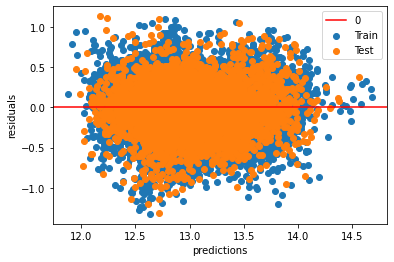

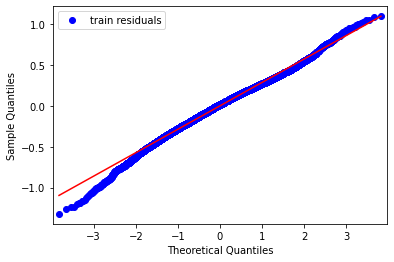

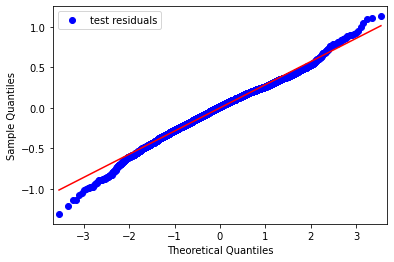

In [90]:
#next we are going to look at waterfront, house_age, and maybe view_NONE
fourth_predictors = ['sqft_living', 'distance', 'waterfront', 'grade_below_average']
fourth_X_train= X_train[fourth_predictors]
fourth_X_test = X_test[fourth_predictors]
fourth_model = sm.OLS(logged_fsm_y_train, sm.add_constant(fourth_X_train)).fit()
fourth_train_preds = fourth_model.predict(sm.add_constant(fourth_X_train))
fourth_test_preds = fourth_model.predict(sm.add_constant(fourth_X_test))
evaluate(logged_fsm_y_train, fourth_train_preds , logged_fsm_y_test, fourth_test_preds, log=True)

In [91]:
fourth_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     6940.
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        10:59:58   Log-Likelihood:                -2620.7
No. Observations:               15180   AIC:                             5251.
Df Residuals:                   15175   BIC:                             5290.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  12.7954      0.011   1214.304      0.000      12.775      12.816
sqft_living             0.0004   3.91e-06     94.503      0.000       0.000       0.000
distance               -0.0364      0.000    -91.956      0.000      -0.037      -0.036
waterfront              0.6199      0.032     19.440      0.000       0.557       0.682
grade_below_average    -0.2078      0.006    -36.015      0.000      -0.219      -0.196
==============================================================================
Omnibus:                      298.552   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              393.318
Skew:                          -0.255   Prob(JB):                     3.91e-86
Kurtosis:                       3.601   Cond. No.                     2.89e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.89e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Fifth Iteration of Model

In [92]:
# code here to iteratively improve your models
selected_features = ['sqft_living','distance', 'waterfront', 'grade_below_average']
features_to_ignore = ['lat', 'long', 'sqft_living15','grade_int', 'zipcode']
next_possible_feature (X_tr=X_train, X_te=X_test, y_tr=logged_fsm_y_train, \
                       y_te=logged_fsm_y_test, current_features=selected_features, 
                       ignore_features=features_to_ignore)

predictor  test r-squared
7           sqft_lot15        0.658116
9             view_YES        0.658038
15           view_NONE        0.658038
4           sqft_above        0.657659
8   sqft_basement_diff        0.657659
2             sqft_lot        0.657459
16        cond_Average        0.655446
12      view_EXCELLENT        0.655431
17           cond_Fair        0.654503
18           cond_Good        0.654429
20      cond_Very Good        0.653785
0             bedrooms        0.653733
11        view_AVERAGE        0.653361
14           view_GOOD        0.653167
5             yr_built        0.653077
6         yr_renovated        0.652676
13           view_FAIR        0.652455
10           house_age        0.652393
19           cond_Poor        0.651977
1            bathrooms        0.651962
3               floors        0.651888

In [93]:
# defining an empty dataframe to capture the VIF scores
vif_5 = pd.DataFrame()

fifth_X_train = X_train[['sqft_living', 'distance', 'waterfront', 'grade_below_average',\
                         'view_YES']]

# label the scores with their related columns
vif_5["features"] = fifth_X_train.columns

# For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score

vif_5["VIF"] = [variance_inflation_factor(fifth_X_train.values, i) \
                for i in range(len(fifth_X_train.columns))]

vif_5

features       VIF
0          sqft_living  3.977025
1             distance  4.241333
2           waterfront  1.071259
3  grade_below_average  1.665107
4             view_YES  1.236566

Train R2: 0.6508
Test R2: 0.6580
*****
Train RMSE: $159,823.10
Test RMSE: $161,924.92
*****
Train MAE: $110,979.65
Test MAE: $111,448.76
*****


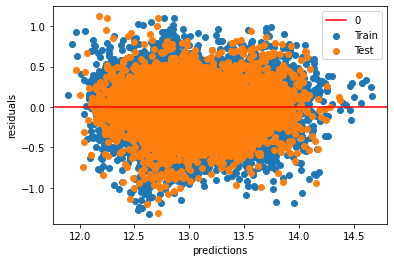

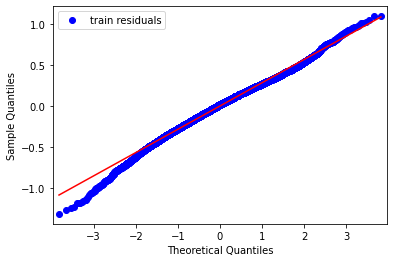

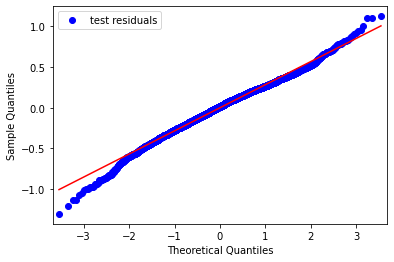

In [94]:
#next we are going to add ''
fifth_predictors = ['sqft_living', 'distance', 'waterfront','grade_below_average',\
                    'view_YES']
fifth_X_train= X_train[fifth_predictors]
fifth_X_test = X_test[fifth_predictors]
fifth_model = sm.OLS(logged_fsm_y_train, sm.add_constant(fifth_X_train)).fit()
fifth_train_preds = fifth_model.predict(sm.add_constant(fifth_X_train))
fifth_test_preds = fifth_model.predict(sm.add_constant(fifth_X_test))
evaluate(logged_fsm_y_train, fifth_train_preds , logged_fsm_y_test, fifth_test_preds, log=True)

In [95]:
fifth_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     5655.
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        11:00:03   Log-Likelihood:                -2529.9
No. Observations:               15180   AIC:                             5072.
Df Residuals:                   15174   BIC:                             5118.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  12.7910      0.010   1220.528      0.000      12.770      12.812
sqft_living             0.0004   3.93e-06     91.899      0.000       0.000       0.000
distance               -0.0356      0.000    -89.280      0.000      -0.036      -0.035
waterfront              0.5124      0.033     15.676      0.000       0.448       0.576
grade_below_average    -0.2044      0.006    -35.616      0.000      -0.216      -0.193
view_YES                0.1220      0.009     13.516      0.000       0.104       0.140
==============================================================================
Omnibus:                      318.445   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              413.645
Skew:                          -0.272   Prob(JB):                     1.51e-90
Kurtosis:                       3.599   Cond. No.                     2.99e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.99e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 6th model iteration

In [96]:
# selected_features = ['sqft_living','distance', 'waterfront', 'grade_below_average', 'view_YES']
# features_to_ignore = ['lat', 'long', 'sqft_living15','grade_int', 'zipcode']
# next_possible_feature (X_tr=X_train, X_te=X_test, y_tr=logged_fsm_y_train, \
#                        y_te=logged_fsm_y_test, current_features=selected_features, 
#                        ignore_features=features_to_ignore)

In [97]:
# defining an empty dataframe to capture the VIF scores
vif_6 = pd.DataFrame()
# features_to_ignore.append('grade_below_average')
# selected_features.remove('grade_below_average')
# selected_features.append('grade_above_average')
sixth_X_train = X_train[['sqft_living', 'distance', 'waterfront','grade_above_average','view_YES']]

# label the scores with their related columns
vif_6["features"] = sixth_X_train.columns

# For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score

vif_6["VIF"] = [variance_inflation_factor(sixth_X_train.values, i) \
                for i in range(len(sixth_X_train.columns))]

vif_6

features       VIF
0          sqft_living  4.443570
1             distance  3.806181
2           waterfront  1.072407
3  grade_above_average  1.190061
4             view_YES  1.236229

In [98]:
# vif_6 = pd.DataFrame()
# features_to_ignore.append('sqft_above')
# selected_features.remove('sqft_above')
# selected_features.append('sqft_lot')
# sixth_X_train = X_train[selected_features]

# # label the scores with their related columns
# vif_6["features"] = sixth_X_train.columns

# # For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score

# vif_6["VIF"] = [variance_inflation_factor(sixth_X_train.values, i) \
#                 for i in range(len(sixth_X_train.columns))]

# vif_6

Train R2: 0.6292
Test R2: 0.6291
*****
Train RMSE: $161,431.43
Test RMSE: $166,492.14
*****
Train MAE: $113,422.23
Test MAE: $115,491.69
*****


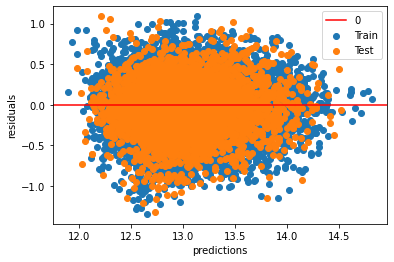

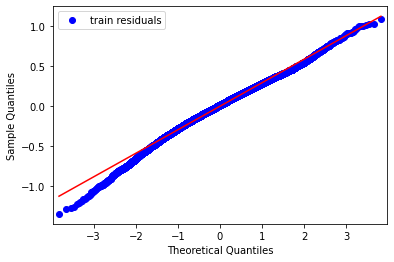

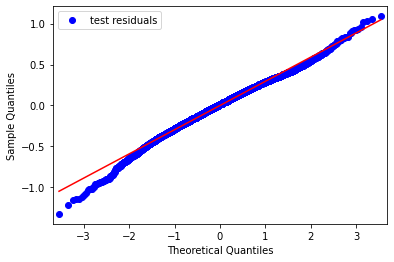

In [99]:
#Let's see if logged_sqft_living has a better effect on the model
sixth_predictors = ['sqft_living', 'distance', 'waterfront','grade_above_average','view_YES']
sixth_X_train= X_train[sixth_predictors]
sixth_X_test = X_test[sixth_predictors]
sixth_model = sm.OLS(logged_fsm_y_train, sm.add_constant(sixth_X_train)).fit()
sixth_train_preds = sixth_model.predict(sm.add_constant(sixth_X_train))
sixth_test_preds = sixth_model.predict(sm.add_constant(sixth_X_test))
evaluate(logged_fsm_y_train, sixth_train_preds , logged_fsm_y_test, sixth_test_preds, log=True)

In [100]:
sixth_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     5150.
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        11:00:06   Log-Likelihood:                -2984.7
No. Observations:               15180   AIC:                             5981.
Df Residuals:                   15174   BIC:                             6027.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  12.5630      0.008   1585.304      0.000      12.548      12.579
sqft_living             0.0004   3.62e-06    114.792      0.000       0.000       0.000
distance               -0.0357      0.000    -86.817      0.000      -0.036      -0.035
waterfront              0.4769      0.034     14.155      0.000       0.411       0.543
grade_above_average     0.2085      0.012     17.670      0.000       0.185       0.232
view_YES                0.1317      0.009     14.159      0.000       0.113       0.150
==============================================================================
Omnibus:                      371.651   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              460.752
Skew:                          -0.318   Prob(JB):                    8.89e-101
Kurtosis:                       3.568   Cond. No.                     2.99e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.99e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 7th model iteration will continuing adding new features so long as they aren't multicollinear

### Since we know from an earlier model that 'logged_sqft_living' is multicollinear, our last predictor will be 'view_YES'. Technically we could use 'view_NONE' but 'view_YES' is a positve correlation instead of a negative correlation

### 'Final' Model

In the end, you'll arrive at a 'final' model - aka the one you'll use to make your recommendations/conclusions. This likely blends any group work. It might not be the one with the highest scores, but instead might be considered 'final' or 'best' for other reasons.

Train R2: 0.6508
Test R2: 0.6580
*****
Train RMSE: $159,823.10
Test RMSE: $161,924.92
*****
Train MAE: $110,979.65
Test MAE: $111,448.76
*****


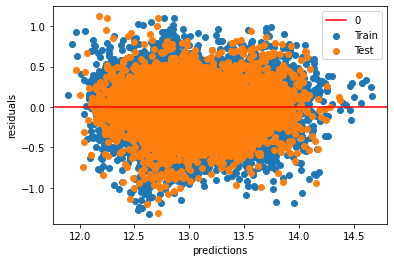

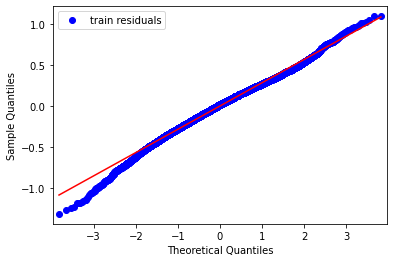

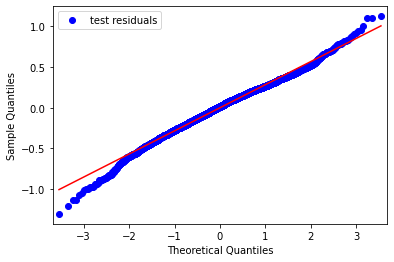

In [101]:
# code here to show your final model
final_predictors = ['sqft_living', 'distance', 'waterfront','grade_below_average','view_YES']
final_X_train= X_train[final_predictors]
final_X_test = X_test[final_predictors]
final_model = sm.OLS(logged_fsm_y_train, sm.add_constant(final_X_train)).fit()
final_train_preds = final_model.predict(sm.add_constant(final_X_train))
final_test_preds = final_model.predict(sm.add_constant(final_X_test))
evaluate(logged_fsm_y_train, final_train_preds , logged_fsm_y_test, final_test_preds, log=True)

In [102]:
# print(f"Train R2: {r2_score(y_train, train_preds):.4f}")
# print(f"Test R2: {r2_score(y_test, test_preds):.4f}")
# print("*****")
# y_tr_unlog = np.exp(y_train)
# tr_pred_unlog=np.exp(train_preds)
# y_te_unlog=np.exp(y_test)
# te_pred_unlog=np.exp(test_preds)
# print(f"Train RMSE: ${mean_squared_error(y_tr_unlog, tr_pred_unlog, squared=False):,.2f}")
# print(f"Test RMSE: ${mean_squared_error(y_te_unlog, te_pred_unlog, squared=False):,.2f}")
# print("*****")
# print(f"Train MAE: ${mean_absolute_error(y_tr_unlog, tr_pred_unlog):,.2f}")
# print(f"Test MAE: ${mean_absolute_error(y_te_unlog, te_pred_unlog):,.2f}")
# print("*****")

# # Calculate our residuals 
# train_residuals = y_train - train_preds
# test_residuals = y_test - test_preds
    
# # Scatter plot 
# plt.scatter(train_preds, train_residuals, label = 'Train')
# plt.scatter(test_preds, test_residuals, label = 'Test')
    
# plt.axhline(y=0, color = 'red', label = '0')
# plt.xlabel('predictions')
# plt.ylabel('residuals')
# plt.legend()  
# plt.show()

In [103]:
# sm.qqplot(train_residuals, line = 'r', label = 'train residuals');
# plt.legend()
# plt.show()  

In [104]:
# sm.qqplot(test_residuals, line = 'r', label = 'test residuals');
# plt.legend()
# plt.show()  

In [105]:
# code here to evaluate your final model
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     5655.
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        11:00:08   Log-Likelihood:                -2529.9
No. Observations:               15180   AIC:                             5072.
Df Residuals:                   15174   BIC:                             5118.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  12.7910      0.010   1220.528      0.000      12.770      12.812
sqft_living             0.0004   3.93e-06     91.899      0.000       0.000       0.000
distance               -0.0356      0.000    -89.280      0.000      -0.036      -0.035
waterfront              0.5124      0.033     15.676      0.000       0.448       0.576
grade_below_average    -0.2044      0.006    -35.616      0.000      -0.216      -0.193
view_YES                0.1220      0.009     13.516      0.000       0.104       0.140
==============================================================================
Omnibus:                      318.445   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              413.645
Skew:                          -0.272   Prob(JB):                     1.51e-90
Kurtosis:                       3.599   Cond. No.                     2.99e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.99e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### To compare the predictors with each other, we should scale them:

In [107]:
# Import the relevant scaler
from sklearn.preprocessing import StandardScaler

# Instantiate a new scaler
scaler = StandardScaler()
# Learn the pattern from the training data
scaler.fit(final_X_train)
#Apply the pattern to the training and testing data
X_train_scaled = scaler.transform(final_X_train)
X_test_scaled = scaler.transform(final_X_test)
X_train_scaled = pd.DataFrame(X_train_scaled,
                              columns=final_X_train.columns,
                              index=final_X_train.index)

X_train_scaled.head()

sqft_living  distance  waterfront  grade_below_average  view_YES
8602      0.020563  0.703125   -0.073697            -1.078286  3.351428
3799      0.376842 -1.377576   -0.073697            -1.078286 -0.298380
12650    -0.322270  1.328061   -0.073697             0.927398 -0.298380
16127     0.538176 -0.968243   -0.073697             0.927398 -0.298380
152      -0.981049  1.389356   -0.073697             0.927398 -0.298380

In [108]:
scaled_final_model = sm.OLS(logged_fsm_y_train, sm.add_constant(X_train_scaled)).fit()

In [109]:
scaled_final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     5655.
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        11:08:13   Log-Likelihood:                -2529.9
No. Observations:               15180   AIC:                             5072.
Df Residuals:                   15174   BIC:                             5118.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  13.0149      0.002   5608.509      0.000      13.010      13.019
sqft_living             0.2685      0.003     91.899      0.000       0.263       0.274
distance               -0.2121      0.002    -89.280      0.000      -0.217      -0.207
waterfront              0.0376      0.002     15.676      0.000       0.033       0.042
grade_below_average    -0.1019      0.003    -35.616      0.000      -0.108      -0.096
view_YES                0.0334      0.002     13.516      0.000       0.029       0.038
==============================================================================
Omnibus:                      318.445   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              413.645
Skew:                          -0.272   Prob(JB):                     1.51e-90
Kurtosis:                       3.599   Cond. No.                         2.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### The strongest predictor in our model is the sqft_living. It has positive effect on the house price. 
### The second strongest is the distance, it has negative effect on the house price.
### Third strongest is the grade_below_average, fourth is waterfront.
### The last strongest is view_YES. Having a view or not have less effect on the price of the house. 

### Unscaled final model interpretation:

In [110]:
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     5655.
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        11:13:54   Log-Likelihood:                -2529.9
No. Observations:               15180   AIC:                             5072.
Df Residuals:                   15174   BIC:                             5118.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  12.7910      0.010   1220.528      0.000      12.770      12.812
sqft_living             0.0004   3.93e-06     91.899      0.000       0.000       0.000
distance               -0.0356      0.000    -89.280      0.000      -0.036      -0.035
waterfront              0.5124      0.033     15.676      0.000       0.448       0.576
grade_below_average    -0.2044      0.006    -35.616      0.000      -0.216      -0.193
view_YES                0.1220      0.009     13.516      0.000       0.104       0.140
==============================================================================
Omnibus:                      318.445   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              413.645
Skew:                          -0.272   Prob(JB):                     1.51e-90
Kurtosis:                       3.599   Cond. No.                     2.99e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.99e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### In this model, the target variable, price, is in its log-transformed state, and the predictors are in its original metric.To interpret the amount of change in the original metric of the outcome:
- we first exponentiate the coefficient of the predictor by exp(coef)
- we then calculate the percent change by (exp(coef) - 1)*100


#### Sqft_living coefficient
One 1 sqft increase in the living area, the price increases by 0.04 percent.

Every 100 sqft increase in the living area, the price increases by 4 percent.

In [118]:
(np.exp(0.0004)-1)*100 

0.040008001066782484

#### Distance coefficient
One mile increase in distance, the price decreases by 3.5 percent.

In [117]:
(np.exp(-0.0356)-1)*100 

-3.4973773217969684

#### Waterfront coefficient
If the house is on the waterfront, the price increases by 66 percent.

In [119]:
(np.exp(0.5124)-1)*100

66.9292693691532

#### Grade_below_average coefficent
If the house has below than the average grade, the price decreases by 18 percent.

In [120]:
(np.exp(-0.2044)-1)*100

-18.48637485328899

#### View_YES coefficent
If the house has a view, the price increases by 12 percent.

In [121]:
(np.exp(0.1220)-1)*100

12.975410178031876

## Conclusions

Provide your conclusions about the work you've done, including any limitations or next steps.

Questions to consider:

- What would you recommend the business do as a result of this work?
- What are some reasons why your analysis might not fully solve the business problem?
- What else could you do in the future to improve this project (future work)?
